# Nearest Lat/Lon Points in xarray

It is very handy to pluck points from an xarray dataset that are nearest a latitude/longitude point of interest. One example is comparing station observations to model data at that point.

For some background, read my post on [StakOverflow: xarray select nearest lat/lon with multi-dimension coordinates](https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates). 

My initial implementation was my `pluck_points` function. It finds the nearest grid point to a lat/lon point by finding the absolute minimum value in the point and grid difference.

My new implementation relys on MetPy ability to determine the x and y values based on the map projection. The benefit of this is that it enables us to use xarray's powerful `sel()` method to obtain the points. 

The two methods most often match the same points, but sometimes the matches are slightly different.

This notebook shows a benchmar of the two methods.

In [8]:
# The two methods being tested
from herbie.tools import nearest_points
from toolbox.gridded_data import pluck_points

# Get model data
from herbie.archive import Herbie

# Get point data
from synoptic.services import stations_metadata

# Plotting
import matplotlib.pyplot as plt
from toolbox.cartopy_tools import common_features, pc
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Get Model Data
H = Herbie('2021-10-8 12:00', model='HRRR', product='sfc').xarray('TMP:2 m')

🏋🏻‍♂️ Found 2021-Oct-08 12:00 UTC F00 [HRRR] [product=sfc] GRIB2 file from aws and index file from aws.                                                                                                                                                       
📇 Download subset: [HRRR] model [sfc] product run at 2021-Oct-08 12:00 UTC F00                                                            
 cURL from https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20211008/conus/hrrr.t12z.wrfsfcf00.grib2
   1: GRIB_message=71  TMP:2 m above ground:anl


In [3]:
# Get Point Data
a = stations_metadata(radius='UKBKB,100')
points = np.array(list(zip(a.loc['longitude'], a.loc['latitude'])))
names = a.loc['STID'].to_numpy()

print(f'{len(names):,} stations to match to grid')


 🚚💨 Speedy Delivery from Synoptic API [metadata]: https://api.synopticdata.com/v2/stations/metadata?radius=UKBKB,100&token=🙈HIDDEN

2,587 stations to match to grid


## Match Points
First let's look at the speed for matching just ten points. It doesn't seem the two methods are much different.

In [9]:
%%timeit
ds_nearest = nearest_points(H, points[:10], names[:10])

568 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
ds_pluck = pluck_points(H, points[:10], names[:10])

613 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


but when we try to match more values...the `nearest_points` method works much faster

In [12]:
%%timeit
ds_nearest = nearest_points(H, points[:100], names[:100])

869 ms ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
ds_pluck = pluck_points(H, points[:100], names[:100])

5.93 s ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Scalability
Let's graph the time to compute by number of points to match

In [51]:
t_nearest = []
t_pluck = []
n = []

#num = range(1,10,3):
num = [1, 5, 10, 25, 50] + list(range(100,len(names),500))
for i in num[:]:
    timer = datetime.now()
    ds_nearest = nearest_points(H, points[:i], names[:i])
    t_nearest.append((datetime.now()-timer).total_seconds())
    
    timer = datetime.now()
    ds_pluck = pluck_points(H, points[:i], names[:i])
    t_pluck.append((datetime.now()-timer).total_seconds())
    
    n.append(i)

Text(0.5, 0, 'Number of matched points')

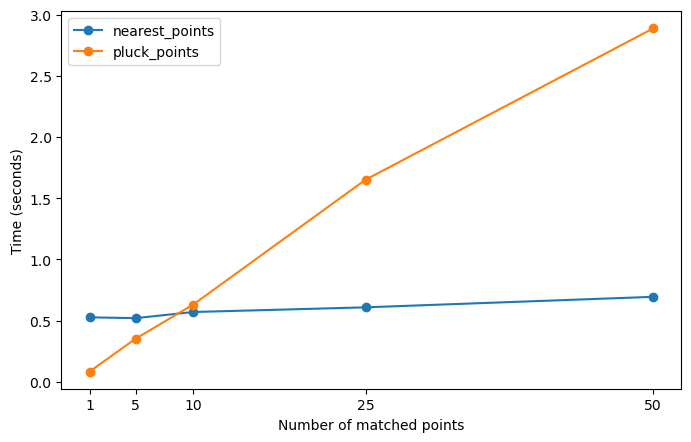

In [54]:
plt.figure(figsize=[8,5], dpi=100)
plt.plot(n[:5], t_nearest[:5], marker='o', label='nearest_points')
plt.plot(n[:5], t_pluck[:5], marker='o', label='pluck_points')
plt.xticks(n[:5])
plt.legend()
plt.ylabel('Time (seconds)')
plt.xlabel('Number of matched points')

Text(0.5, 0, 'Number of matched points')

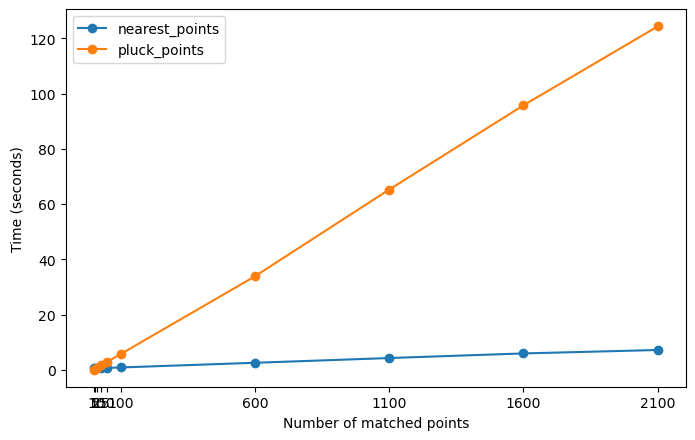

In [52]:
plt.figure(figsize=[8,5], dpi=100)
plt.plot(n, t_nearest, marker='o', label='nearest_points')
plt.plot(n, t_pluck, marker='o', label='pluck_points')
plt.xticks(n)
plt.legend()
plt.ylabel('Time (seconds)')
plt.xlabel('Number of matched points')

**Clearly, the `nearest_points` implementation scales much better.**

I could talk about the implementation of these algorithms with [Big O notation](https://en.wikipedia.org/wiki/Big_O_notation), but I'll save that for the computer scientists. For me, I'm happy just seeing that my new function scales much better.